# gwexpy 時刻操作チュートリアル

このノートブックでは、`gwexpy` で拡張された時刻関連の機能について紹介します。主な改善点は以下の通りです：

1. **ベクトル化された時刻変換**: 大量の時刻データを高速に GPS 時刻へ変換できます。
2. **相互運用性の向上**: Pandas や ObsPy の時刻オブジェクトを直接扱えます。
3. **柔軟な `crop` メソッド**: `TimeSeries` などの切り出しに、GPS 秒だけでなく日付文字列や外部オブジェクトが利用可能です。
4. **`as_series` による変換**: 軸（`gwpy.types.index.Index` / 1D `astropy.units.Quantity`）を `TimeSeries` / `FrequencySeries` に変換します。

## 1. 高速かつ柔軟な時刻変換 (`to_gps`, `tconvert`)

`gwexpy.time` モジュールは `gwpy.time` を拡張しており、リストや Numpy 配列の一括変換をサポートしています。

In [1]:
import numpy as np
import pandas as pd
from gwexpy.time import to_gps, tconvert

# 1. 文字列のリストを一括変換
time_list = ["2025-01-01 00:00:00", "2025-01-01 00:01:00", "2025-01-01 00:02:00"]
gps_arr = to_gps(time_list)
print("GPS array:", gps_arr)

# 2. Pandas オブジェクトのサポート
df_times = pd.date_range("2025-01-01", periods=3, freq="h")
gps_from_pd = to_gps(df_times)
print("GPS from Pandas:", gps_from_pd)

# 3. tconvert を使った相互変換 (数値なら datetime へ、文字列なら GPS へ)
now_gps = tconvert("now")
print(f"Current GPS: {now_gps}")

dt_list = tconvert(gps_arr)
print("Datetime back-conversion:", dt_list)

GPS array: [1.41972482e+09 1.41972488e+09 1.41972494e+09]
GPS from Pandas: [1.41972482e+09 1.41972842e+09 1.41973202e+09]
Current GPS: 1450882748
Datetime back-conversion: [datetime.datetime(2025, 1, 1, 0, 0, 37)
 datetime.datetime(2025, 1, 1, 0, 1, 37)
 datetime.datetime(2025, 1, 1, 0, 2, 37)]


## 2. 柔軟なデータ切り出し (`crop`)

`TimeSeries` などの `crop` メソッドが拡張され、`start` や `end` に直接日付文字列などを指定できるようになりました。

Original span: [1419724818.0 ... 1419728418.0)
Cropped span: [1419725418.0 ... 1419726018.0)
Number of samples: 600


/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


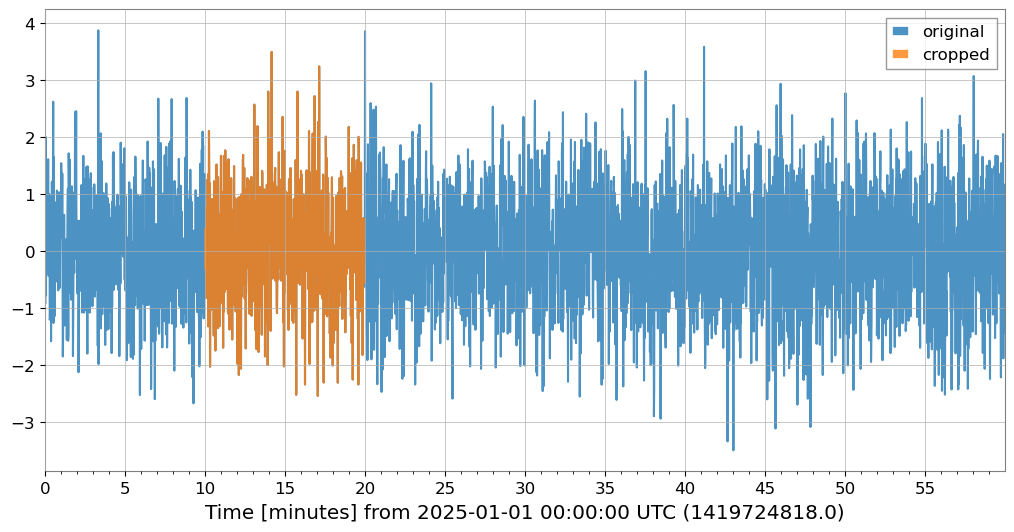

In [2]:
from gwexpy.timeseries import TimeSeries
from gwexpy.time import to_gps
from gwexpy.plot import Plot
import matplotlib.pyplot as plt

# サンプルデータの作成 (2025-01-01 00:00:00 UTC)
t0 = to_gps("2025-01-01 00:00:00")
data = np.random.randn(3600)
ts = TimeSeries(data, t0=t0, dt=1)

print(f"Original span: {ts.span}")

# GPS 秒の代わりに文字列で切り出し
ts_cropped = ts.crop(start="2025-01-01 00:10:00", end="2025-01-01 00:20:00")

print(f"Cropped span: {ts_cropped.span}")
print(f"Number of samples: {len(ts_cropped)}")
Plot(ts, ts_cropped, alpha=0.8)
plt.legend(["original", "cropped"])
plt.show()

## 3. シリーズオブジェクトの自動生成 (`as_series`)

`as_series` 関数は、1D の軸（`gwpy.types.index.Index` または `astropy.units.Quantity`）を `TimeSeries` / `FrequencySeries` に変換します（値は軸の値を使う identity 変換）。

<class 'gwpy.types.index.Index'>
TimeSeries([394368.005     , 394368.00527778, 394368.00555556,
            ..., 394369.00416667, 394369.00444444,
            394369.00472222]
           unit: h,
           t0: 1419724818.0 s,
           dt: 1.0 s,
           name: None,
           channel: None)


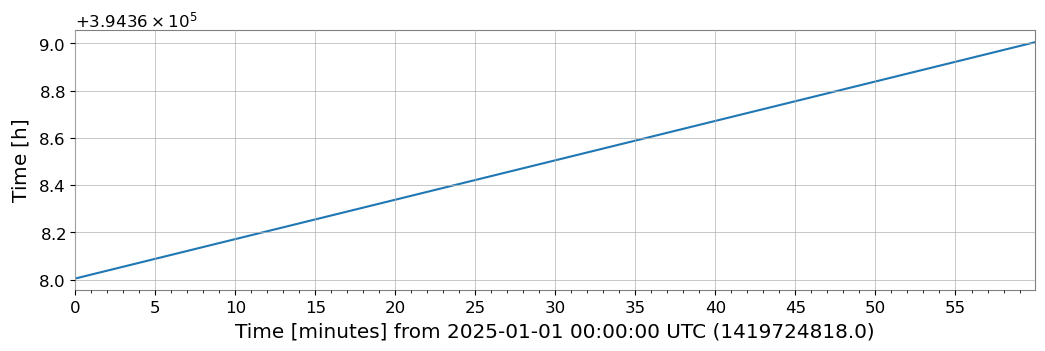

<class 'gwpy.types.index.Index'>
FrequencySeries([  0.   ,  15.625,  31.25 ,  46.875,  62.5  ,
                  78.125,  93.75 , 109.375, 125.   , 140.625,
                 156.25 , 171.875, 187.5  , 203.125, 218.75 ,
                 234.375, 250.   , 265.625, 281.25 , 296.875,
                 312.5  , 328.125, 343.75 , 359.375, 375.   ,
                 390.625, 406.25 , 421.875, 437.5  , 453.125,
                 468.75 , 484.375, 500.   ]
                unit: mHz,
                f0: 0.0 Hz,
                df: 0.015625 Hz,
                epoch: None,
                name: None,
                channel: None)


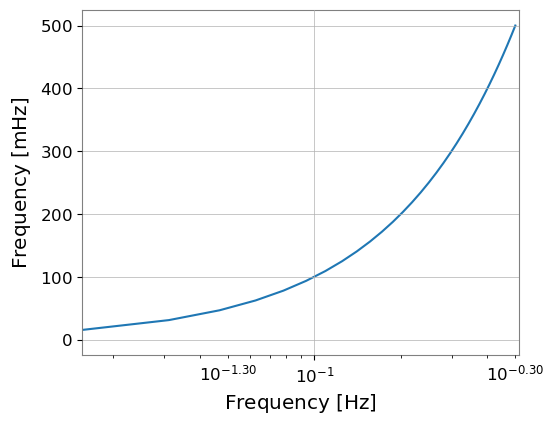

In [3]:
from gwexpy.types import as_series


# Astropy Quantity からの変換と自動単位変換
times = ts.times
ts_from_times = as_series(times, unit='h') # s から h へ自動変換して生成
print(type(times))
print(ts_from_times)
ts_from_times.plot()
plt.show()
plt.close()

frequencies = ts.asd(64,32).frequencies
fs_from_frequencies = as_series(frequencies, unit='mHz') # Hz から mHz へ自動変換して生成
print(type(frequencies))
print(fs_from_frequencies)
fs_from_frequencies.plot()
plt.show()
plt.close()